In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
data_transforms = {
    'train': v2.Compose([
        v2.RandomRotation(30),
        v2.RandomHorizontalFlip(),

        # v2.Resize(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ]),
    'val': v2.Compose([
        # v2.Resize(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': v2.Compose([
        # v2.Resize(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
}


In [5]:
data_dir = 'data/dental-images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=16)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 363
     Root location: data/dental-images/train
     StandardTransform
 Transform: Compose(
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  RandomHorizontalFlip(p=0.5)
                  ToImage()
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 91
     Root location: data/dental-images/val
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 20
     Root location: data/dental-images/test
     StandardTransform
 Transform: Compose(
                  ToImage()
       

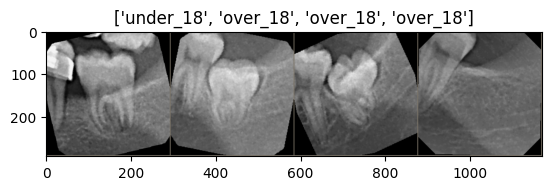

In [7]:
# show images
def imshow(inp, title=None):
    """input is a tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = {'train': {'loss': [], 'acc': []}, 'val': {'loss': [], 'acc': []}}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                history[phase]['loss'].append(epoch_loss)
                # acc is a tensor, so we need to convert it to a float
                history[phase]['acc'].append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, history

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
# model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = models.shufflenet_v2_x2_0(weights='IMAGENET1K_V1')
# model_ft = models.shufflenet_v2_x1_5(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features

# model_ft = models.mnasnet1_3(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.classifier[1].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


ERROR:tornado.general:SEND Error: Host unreachable


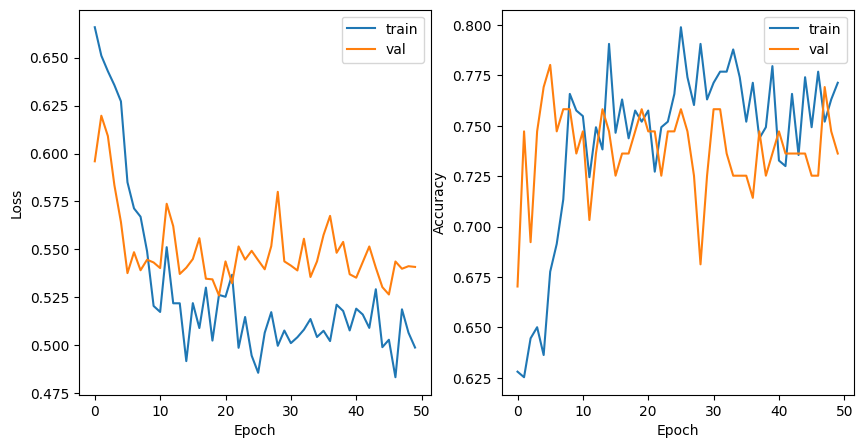

In [11]:
# plot training history in two subplots, one for loss and one for accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ft['train']['loss'], label='train')
plt.plot(history_ft['val']['loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft['train']['acc'], label='train')
plt.plot(history_ft['val']['acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

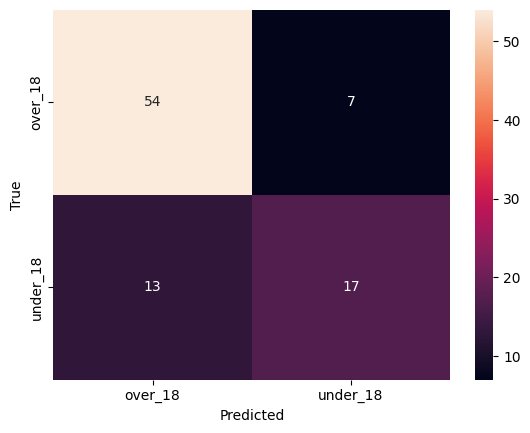

              precision    recall  f1-score   support

     over_18       0.81      0.89      0.84        61
    under_18       0.71      0.57      0.63        30

    accuracy                           0.78        91
   macro avg       0.76      0.73      0.74        91
weighted avg       0.77      0.78      0.77        91



In [12]:
# show confusion matrix of best model

model_ft.eval()
preds = []
true = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, pred = torch.max(outputs, 1)
        preds.extend(pred.cpu().numpy())
        true.extend(labels.cpu().numpy())

cm = confusion_matrix(true, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
seaborn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# show recall, precision and f1-score
print(classification_report(true, preds, target_names=class_names))



Accuracy of the network on the 20 test images: 55.0%
Images wrongly classified: 9


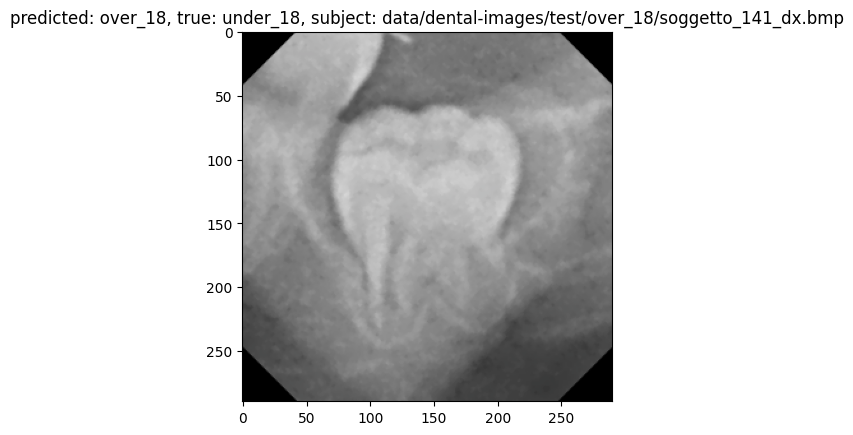

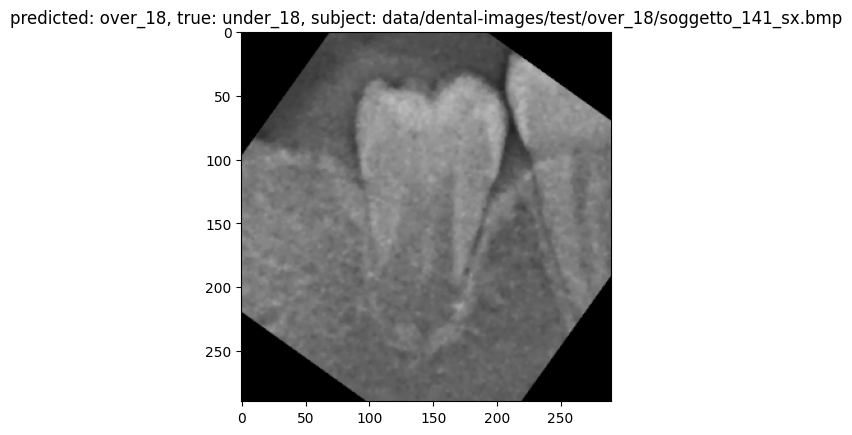

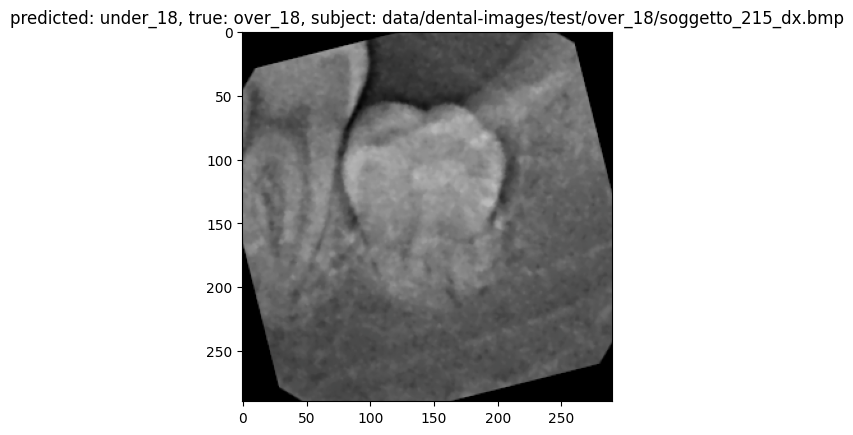

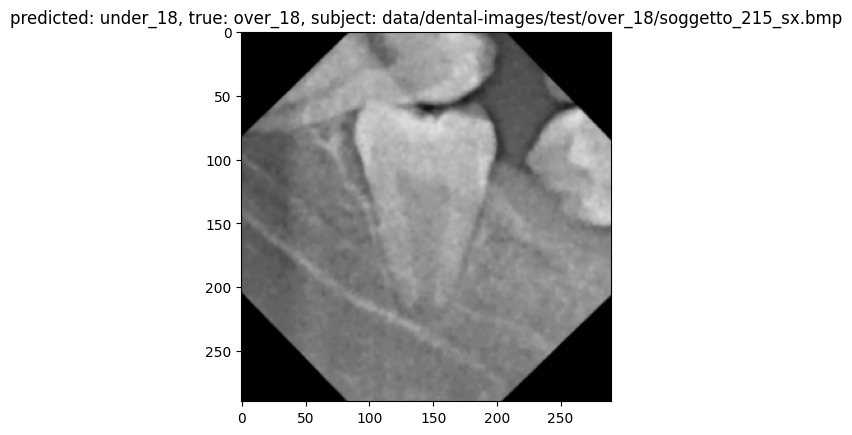

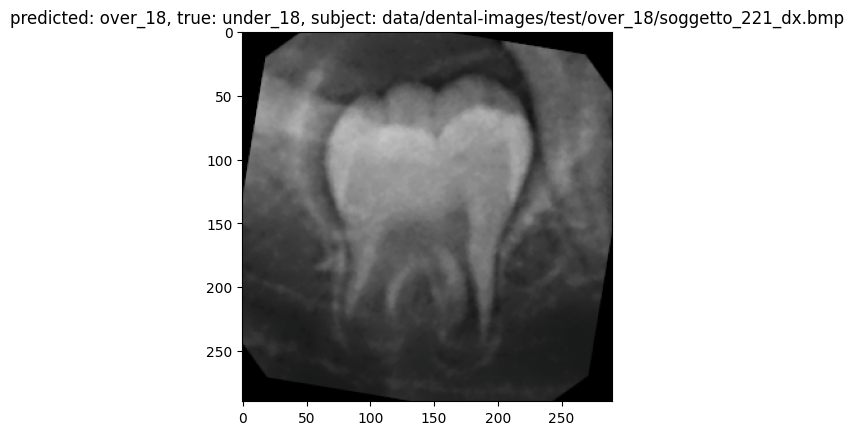

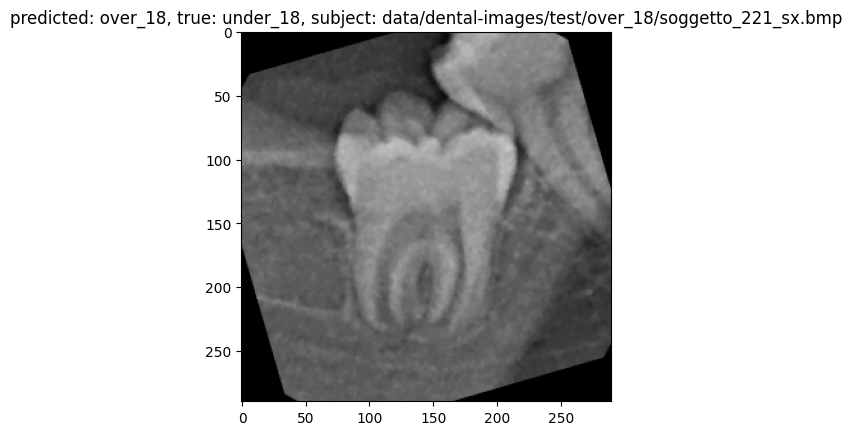

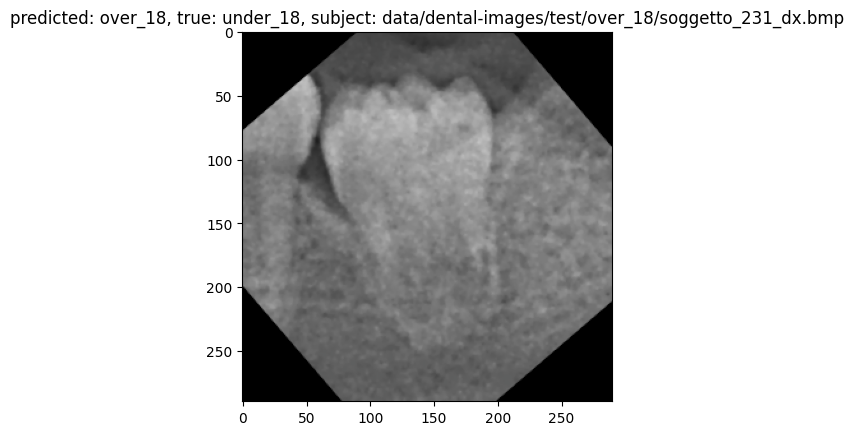

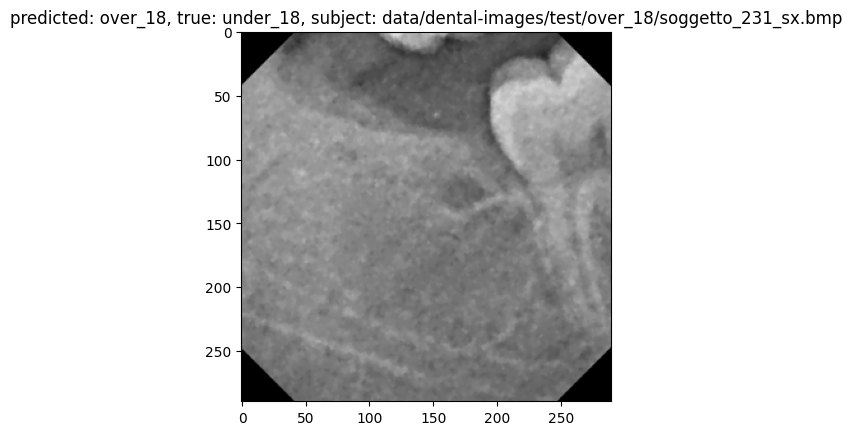

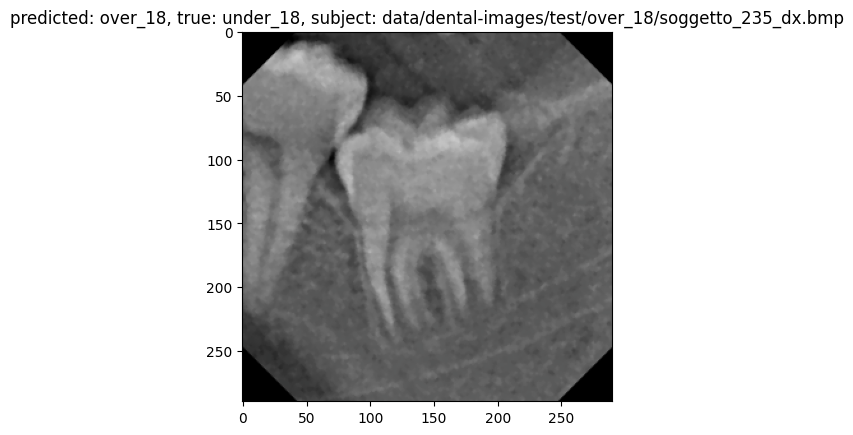

Images correctly classified: 11


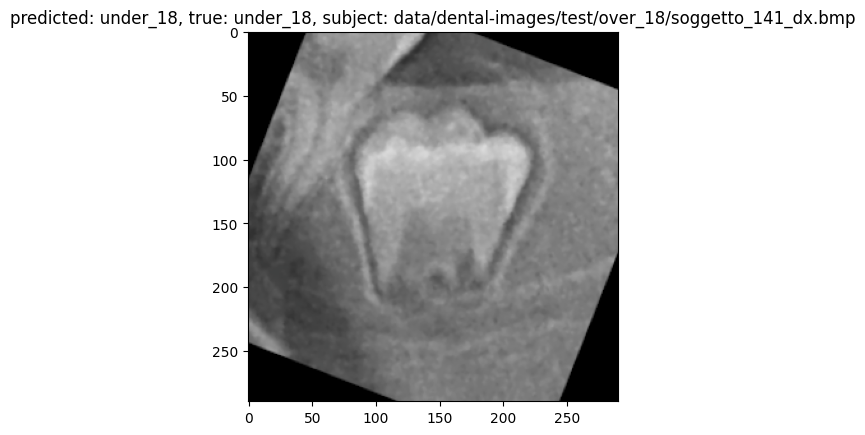

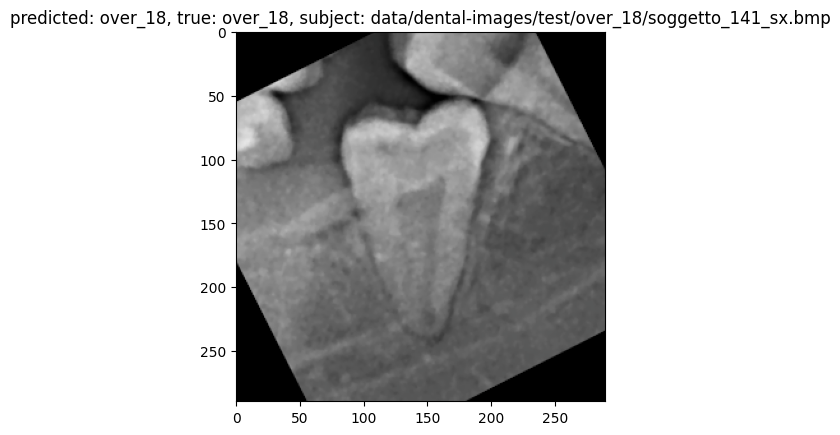

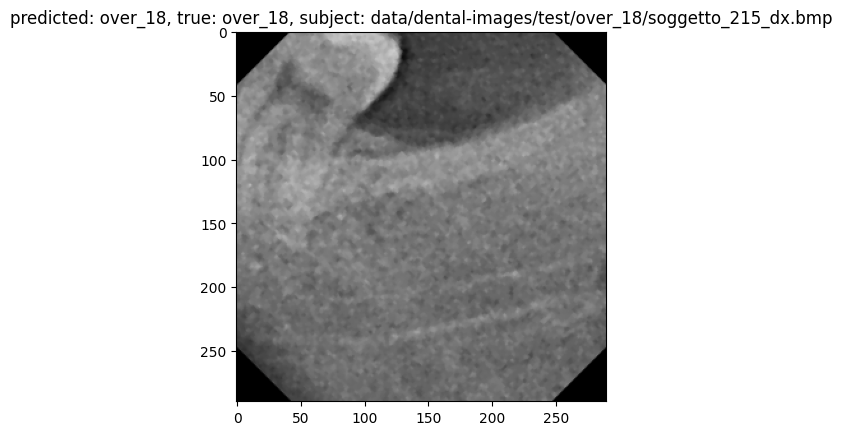

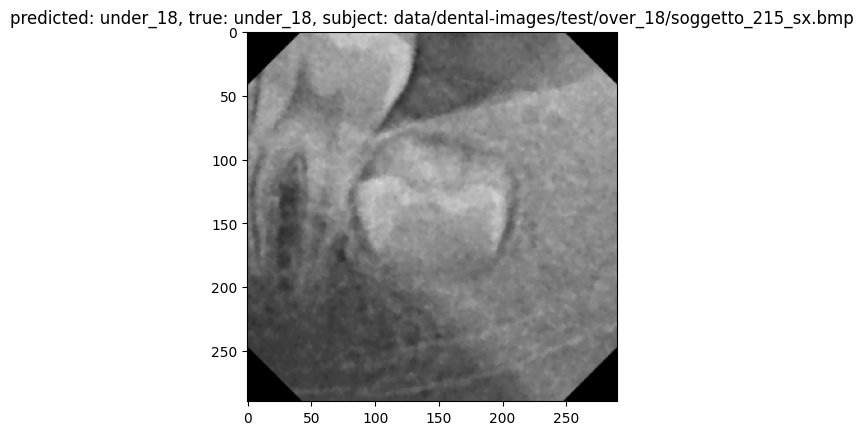

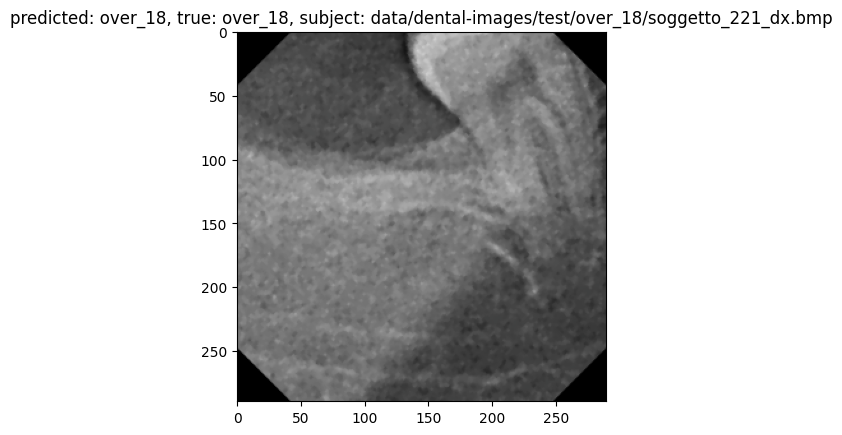

In [15]:
# test the model and plot images wrongly classified
model_ft.eval()

correct = 0
total = 0

correct_images = []
correct_labels = []
correct_preds = []
wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, pred = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (pred == labels).sum().item()

        correct_images.extend(inputs[labels == pred])
        correct_labels.extend(labels[labels == pred])
        correct_preds.extend(pred[labels == pred])
        
        wrong = pred != labels
        wrong_images.extend(inputs[wrong])
        wrong_labels.extend(labels[wrong])
        wrong_preds.extend(pred[wrong])


print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

print(f'Images wrongly classified: {len(wrong_images)}')

for i in range(len(wrong_images)):
    imshow(wrong_images[i].cpu(), title=f'predicted: {class_names[wrong_preds[i]]}, true: {class_names[wrong_labels[i]]}, subject: {image_datasets["test"].samples[i][0]}')
    plt.show()


print(f'Images correctly classified: {len(correct_images)}')
for i in range(5):
    imshow(correct_images[i].cpu(), title=f'predicted: {class_names[correct_preds[i]]}, true: {class_names[correct_labels[i]]}, subject: {image_datasets["test"].samples[i][0]}')
    plt.show()






In [14]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_params = sum(p.numel() for p in model.parameters())
# print number of parameters in millions
print(f'Number of parameters: {num_params / 1e6:.2f}M')

Number of parameters: 11.69M


In [4]:
model = models.vgg16(weights='IMAGENET1K_V1')
num_params = sum(p.numel() for p in model.parameters())
# print number of parameters in millions
print(f'Number of parameters: {num_params / 1e6:.2f}M')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/antonio/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


Number of parameters: 138.36M


In [14]:
# compare with a smaller model
model = models.shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
num_params = sum(p.numel() for p in model.parameters())
# print number of parameters in millions
print(f'Number of parameters: {num_params / 1e6:.2f}M')

Number of parameters: 1.37M


In [15]:
# smaller model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_params = sum(p.numel() for p in model.parameters())
# print number of parameters in millions
print(f'Number of parameters: {num_params / 1e6:.2f}M')

Number of parameters: 3.50M


In [5]:
# list all pretrained models in torchvision
import torchvision.models
pretrained_models = [name for name in torchvision.models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(torchvision.models.__dict__[name])]
pretrained_models

['alexnet',
 'convnext_tiny',
 'convnext_small',
 'convnext_base',
 'convnext_large',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_s',
 'efficientnet_v2_m',
 'efficientnet_v2_l',
 'googlenet',
 'inception_v3',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_1_6gf',
 'regnet_y_3_2gf',
 'regnet_y_8gf',
 'regnet_y_16gf',
 'regnet_y_32gf',
 'regnet_y_128gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_1_6gf',
 'regnet_x_3_2gf',
 'regnet_x_8gf',
 'regnet_x_16gf',
 'regnet_x_32gf',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'resnext50_32x4d',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'wide_resnet50_2',
 'wide_resnet101_2',
 'shufflenet_v2_x0_5',

In [80]:
import torch
# get number of parameters for each model pretrained on ImageNet
model_params = {}
for model_name in pretrained_models:
    try:
        weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", model_name)
        for weight in weight_enum:
            model = getattr(torchvision.models, model_name)(weights=weight)
            num_params = sum(p.numel() for p in model.parameters())

            # remove model name from weight
            weight = str(weight).split('.')[-1]
            model_params[f'{model_name}_{weight}'] = {'num_params': num_params}
            
    
            

    except Exception as e:
        print(f'Error for {model_name}: {e}')


# sort models by number of parameters
sorted_models = sorted(model_params.items(), key=lambda x: x[1]['num_params'], reverse=True)




Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_visi

Error for get_model: Unknown model get_model
Error for get_model_builder: Unknown model get_model_builder
Error for get_model_weights: Unknown model get_model_weights
Error for get_weight: Unknown model get_weight
Error for list_models: Unknown model list_models


Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/antonio/.cache/torch/hub/pytorch_vision_main


In [81]:
# print sorted models
for model, params in sorted_models:
    print(f'{model}: {params["num_params"] / 1e6:.2f}M')

    

regnet_y_128gf_IMAGENET1K_SWAG_E2E_V1: 644.81M
regnet_y_128gf_IMAGENET1K_SWAG_LINEAR_V1: 644.81M
vit_h_14_IMAGENET1K_SWAG_E2E_V1: 633.47M
vit_h_14_IMAGENET1K_SWAG_LINEAR_V1: 632.05M
vit_l_32_IMAGENET1K_V1: 306.54M
vit_l_16_IMAGENET1K_SWAG_E2E_V1: 305.17M
vit_l_16_IMAGENET1K_V1: 304.33M
vit_l_16_IMAGENET1K_SWAG_LINEAR_V1: 304.33M
convnext_large_IMAGENET1K_V1: 197.77M
regnet_y_32gf_IMAGENET1K_V1: 145.05M
regnet_y_32gf_IMAGENET1K_V2: 145.05M
regnet_y_32gf_IMAGENET1K_SWAG_E2E_V1: 145.05M
regnet_y_32gf_IMAGENET1K_SWAG_LINEAR_V1: 145.05M
vgg19_bn_IMAGENET1K_V1: 143.68M
vgg19_IMAGENET1K_V1: 143.67M
vgg16_bn_IMAGENET1K_V1: 138.37M
vgg16_IMAGENET1K_V1: 138.36M
vgg16_IMAGENET1K_FEATURES: 138.36M
vgg13_bn_IMAGENET1K_V1: 133.05M
vgg13_IMAGENET1K_V1: 133.05M
vgg11_bn_IMAGENET1K_V1: 132.87M
vgg11_IMAGENET1K_V1: 132.86M
wide_resnet101_2_IMAGENET1K_V1: 126.89M
wide_resnet101_2_IMAGENET1K_V2: 126.89M
efficientnet_v2_l_IMAGENET1K_V1: 118.52M
regnet_x_32gf_IMAGENET1K_V1: 107.81M
regnet_x_32gf_IMAGENET1K_

In [83]:
# save sorted_models to a json file
import json

with open('sorted_models.json', 'w') as f:
    json.dump(sorted_models, f)

